## Steps
1. Load data from json File
2. Split data into train test split
3. create neural net using using tensorflow and keras
4. Train the network

In [1]:
import json
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
from tqdm.auto import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=8000)])

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Loading the Data

In [4]:
def load_data(dataset_path):
    with open(dataset_path, "r") as fp:
        data = json.load(fp)
    
    x = np.array(data['mfcc'])
    y = np.array(data['labels'])
    num_segments = data['num_segments']
    mapping = data['mapping']
    file_origin = data['file_origin']
    
    
    return x, y, num_segments, mapping, file_origin

In [5]:
x, y, num_segments, mapping, file_origin = load_data("Data/data_32.json")

In [6]:
len(x)

79940

## Helping Functions

In [7]:
def plot_history(history):
    fig, axs = plt.subplots(2, figsize = (15,15))
    
    
    
    #Create accuracy subplot
    
    axs[0].plot(history.history["acc"], label = "train accuracy")
    axs[0].plot(history.history["val_acc"], label = "test accuracy")
    axs[0].set_ylabel("accuracy")
    axs[0].legend(loc = "lower right")
    axs[0].set_title("accuracy eval")
    
    #Create Error subplot
        
    axs[1].plot(history.history["loss"], label = "train error")
    axs[1].plot(history.history["val_loss"], label = "test error")
    axs[1].set_ylabel("error")
    axs[1].set_xlabel("epochs")
    axs[1].legend(loc = "upper right")
    axs[1].set_title("error eval")
    
    plt.show()

In [8]:
def predict(model, X, y):
    X = X[np.newaxis, :]
    
    # prediction = [[0.2, 0,2, ...]] probabilities
    prediction = model.predict(X)
    
    #extrack index with max value (softmax gives you probabilities)
    predicted_index = np.argmax(prediction, axis = 1)
    
    print("The prediction is: {}, The expected output is: {}".format(mapping[int(predicted_index)], mapping[y]))

In [9]:
#create label encoder for inverse fit
encoder = LabelEncoder()
encoder.classes_ = mapping

## Create Train Test split

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x,y)

## Creating Model Structure (Simple Dense Model)

In [44]:
#this is going to be a basic neural network consisting of only dense layers
model_1 = keras.Sequential([
    #input layer
    keras.layers.Flatten(input_shape = (x.shape[1], x.shape[2])),
    
    #1st hidden layer
    keras.layers.Dense(512, activation = "relu"),
    
    #2nd hidden layers
    keras.layers.Dense(256, activation = "relu"),
    
    #3rd hidden layers
    keras.layers.Dense(64, activation = "relu"),
    
    keras.layers.Dense(len(mapping), activation = "softmax")
    
])

In [45]:
optimizer = keras.optimizers.Adam(learning_rate = 0.0001)
model_1.compile(optimizer = optimizer, loss = "sparse_categorical_crossentropy", metrics = ["acc"])
model_1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 4128)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               2114048   
_________________________________________________________________
dense_7 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_8 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_9 (Dense)              (None, 8)                 520       
Total params: 2,262,344
Trainable params: 2,262,344
Non-trainable params: 0
_________________________________________________________________


## Training The Model

In [46]:
#this model overfits greatly
history_1 = model_1.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 50, batch_size = 128)

Epoch 1/50
469/469 [==============================] - 2s 3ms/step - loss: 3.2513 - acc: 0.2163 - val_loss: 1.9787 - val_acc: 0.2565
Epoch 2/50
469/469 [==============================] - 1s 3ms/step - loss: 1.9055 - acc: 0.2827 - val_loss: 1.8941 - val_acc: 0.3000
Epoch 3/50
469/469 [==============================] - 1s 3ms/step - loss: 1.8024 - acc: 0.3256 - val_loss: 1.8473 - val_acc: 0.3175
Epoch 4/50
469/469 [==============================] - 1s 3ms/step - loss: 1.7122 - acc: 0.3644 - val_loss: 1.8110 - val_acc: 0.3425
Epoch 5/50
469/469 [==============================] - 1s 3ms/step - loss: 1.6319 - acc: 0.3945 - val_loss: 1.7818 - val_acc: 0.3643
Epoch 6/50
469/469 [==============================] - 1s 3ms/step - loss: 1.5479 - acc: 0.4276 - val_loss: 1.7532 - val_acc: 0.3712
Epoch 7/50
469/469 [==============================] - 1s 3ms/step - loss: 1.4733 - acc: 0.4573 - val_loss: 1.7576 - val_acc: 0.3772
Epoch 8/50
469/469 [==============================] - 1s 3ms/step - loss: 1.

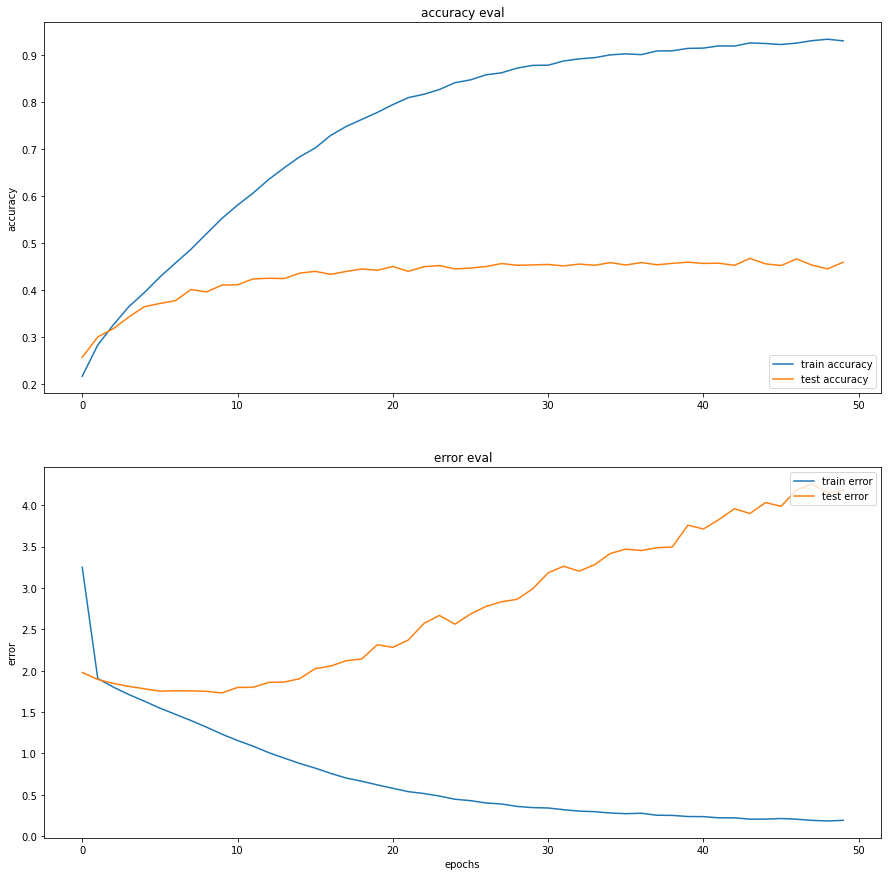

In [47]:
plot_history(history_1)

## Creating Model Structure (Convnet)

In [11]:
x_train_cnn = np.expand_dims(x_train, axis = -1)
x_test_cnn = np.expand_dims(x_test, axis = -1)

In [12]:
x_train_cnn.shape

(59955, 129, 32, 1)

In [50]:
input_shape = x_train_cnn.shape[1:]
model_cnn = keras.Sequential([
    #1st convlayer (input)
    keras.layers.Conv2D(32, (3,3), strides=1,padding = 'same',input_shape = input_shape, activation = 'relu'),
    #Downsizing MaxPool layer
    keras.layers.Conv2D(32, (3,3), strides=1,padding = 'same',activation = 'relu'),
    keras.layers.MaxPool2D((3,3), strides = (2,2), padding = 'same'),
    #normalizes activation
    keras.layers.BatchNormalization(),
                        
    #2nd conv layer
    keras.layers.Conv2D(64, (3,3),strides=1,padding = 'same', activation = 'relu'),
    keras.layers.Conv2D(64, (3,3), strides=1,padding = 'same',activation = 'relu'),
    keras.layers.MaxPool2D((3,3), strides = (2,2), padding = 'same'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(128, (3,3),strides=1,padding = 'same', activation = 'relu'),
    keras.layers.Conv2D(128, (3,3), strides=1,padding = 'same',activation = 'relu'),
    keras.layers.MaxPool2D((3,3), strides = (2,2), padding = 'same'),
    keras.layers.BatchNormalization(),


    keras.layers.Dropout(0.3),                    
    #flatten the output to feed to dense output layer
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation = 'relu'),
    keras.layers.Dropout(0.3),
                    
    #Dense output layer
    keras.layers.Dense(len(mapping), activation = 'softmax')
])

In [51]:
optimizer = keras.optimizers.Adam(learning_rate = 0.0001)
model_cnn.compile(optimizer = optimizer, loss = "sparse_categorical_crossentropy", metrics = ["acc"])
model_cnn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 129, 32, 32)       320       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 129, 32, 32)       9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 65, 16, 32)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 65, 16, 32)        128       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 65, 16, 64)        18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 65, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 33, 8, 64)        

## Training the Model

In [52]:
history_cnn = model_cnn.fit(x_train_cnn, y_train, validation_data = (x_test_cnn, y_test), batch_size = 128, epochs = 30)

Epoch 1/30
469/469 [==============================] - 14s 29ms/step - loss: 1.7588 - acc: 0.3594 - val_loss: 1.6164 - val_acc: 0.4164
Epoch 2/30
469/469 [==============================] - 13s 28ms/step - loss: 1.5652 - acc: 0.4421 - val_loss: 1.4853 - val_acc: 0.4727
Epoch 3/30
469/469 [==============================] - 13s 28ms/step - loss: 1.4793 - acc: 0.4741 - val_loss: 1.3755 - val_acc: 0.5139
Epoch 4/30
469/469 [==============================] - 13s 28ms/step - loss: 1.4087 - acc: 0.4974 - val_loss: 1.3982 - val_acc: 0.5003
Epoch 5/30
469/469 [==============================] - 13s 28ms/step - loss: 1.3453 - acc: 0.5194 - val_loss: 1.2857 - val_acc: 0.5430
Epoch 6/30
469/469 [==============================] - 13s 28ms/step - loss: 1.2829 - acc: 0.5443 - val_loss: 1.2499 - val_acc: 0.5643
Epoch 7/30
469/469 [==============================] - 13s 28ms/step - loss: 1.2308 - acc: 0.5625 - val_loss: 1.2109 - val_acc: 0.5703
Epoch 8/30
469/469 [==============================] - 13s 28ms

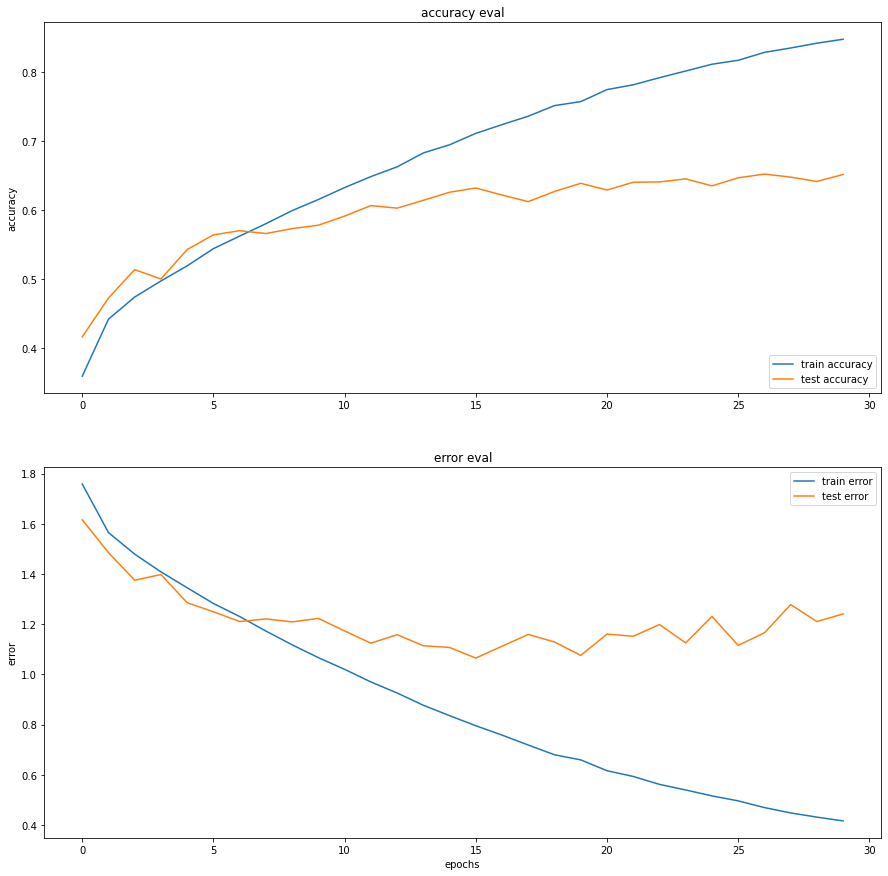

In [57]:
plot_history(history_cnn)

In [55]:
#export the model
model_cnn.save("models/cnn_model_32.h5")

In [12]:
#Load the Model to save time
model_cnn = tf.keras.models.load_model('models/cnn_model_32.h5')

In [ ]:
#Homework
#Presentation
#Data Visualization

In [ ]:
test_case = 106
x_case = x_test_cnn[test_case]
y_case = y_test[test_case]
predict(model_cnn, x_case, y_case)

In [31]:
from sklearn.metrics import confusion_matrix

In [32]:
x.shape

(79940, 129, 13)

In [17]:
prediction_y = model_cnn.predict(np.expand_dims(x, axis = 3))

In [18]:
predictions = np.argmax(prediction_y, axis = -1)

In [35]:
cm = confusion_matrix(y, predictions)

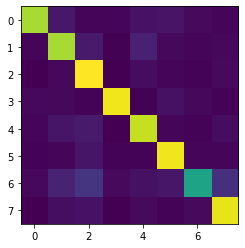

In [56]:
plt.imshow(cm)

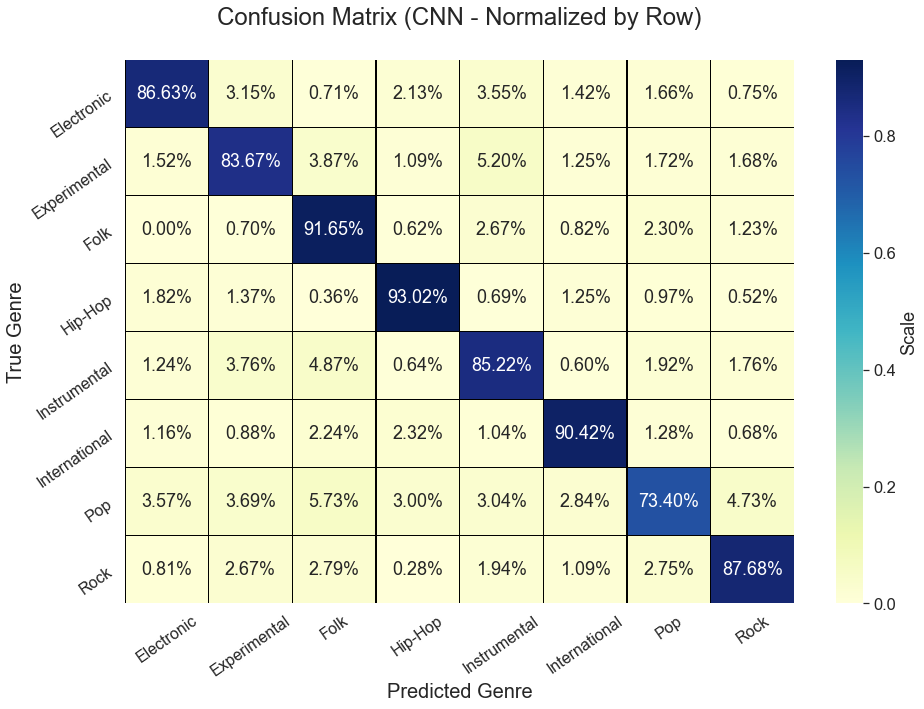

In [29]:
import seaborn
import matplotlib.pyplot as plt
 
 
def plot_confusion_matrix(data, labels, output_filename):
    """Plot confusion matrix using heatmap.
 
    Args:
        data (list of list): List of lists with confusion matrix data.
        labels (list): Labels which will be plotted across x and y axis.
        output_filename (str): Path to output file.
 
    """
    seaborn.set(color_codes=True)
    plt.figure(1, figsize=(15, 10))
 
    plt.title("Confusion Matrix (CNN - Normalized by Row)", fontsize=24, pad=35)
    
    seaborn.set(font_scale=1.5)
    ax = seaborn.heatmap(data, annot=True, cmap="YlGnBu", fmt=".2%", linewidths=.4, linecolor='black',cbar_kws={'label': 'Scale'})
    
    ax.set_xticklabels(labels, rotation=35, fontsize=16)
    ax.set_yticklabels(labels, rotation=35, fontsize=16)
 
    
    plt.ylabel('True Genre', fontsize=20)
    plt.xlabel('Predicted Genre', fontsize=20)

    plt.savefig(output_filename, bbox_inches='tight', dip=1200)
    plt.show()
    plt.close()
 
#getting the confusion matrix
from sklearn.metrics import confusion_matrix
prediction_y = model_cnn.predict(x_test_cnn)
predictions = np.argmax(prediction_y, axis = -1)
cm = confusion_matrix(y_test, predictions, normalize='true')

# create confusion matrix
plot_confusion_matrix(cm, mapping, "graphs/confusion_matrix.png")

## RNN-LSTM Model

In [24]:
input_shape = x.shape[1:]
model_lstm = keras.Sequential()

#2 lstm layers
model_lstm.add(keras.layers.LSTM(64, input_shape = input_shape, return_sequences = True))
model_lstm.add(keras.layers.LSTM(64))

#dense layer
model_lstm.add(keras.layers.Dense(64, activation = "relu"))

#dropout layer
model_lstm.add(keras.layers.Dropout(0.3))

#output layer
model_lstm.add(keras.layers.Dense(len(mapping), activation = 'softmax'))


In [40]:
optimizer = keras.optimizers.Adam(learning_rate = 0.0001)
model_lstm.compile(optimizer = optimizer, loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])
model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 129, 64)           19968     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 520       
Total params: 57,672
Trainable params: 57,672
Non-trainable params: 0
_________________________________________________________________


In [26]:
history_lstm = model_lstm.fit(x_train, y_train, validation_data = (x_test, y_test), batch_size = 128, epochs = 30)


W0721 10:53:05.313315 139902445979456 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 59955 samples, validate on 19985 samples
Epoch 1/30
59955/59955 [==============================] - 130s 2ms/sample - loss: 1.9550 - acc: 0.2452 - val_loss: 1.8089 - val_acc: 0.3297
Epoch 2/30
59955/59955 [==============================] - 128s 2ms/sample - loss: 1.7964 - acc: 0.3269 - val_loss: 1.7372 - val_acc: 0.3569
Epoch 3/30
59955/59955 [==============================] - 128s 2ms/sample - loss: 1.7436 - acc: 0.3527 - val_loss: 1.6987 - val_acc: 0.3732
Epoch 4/30
59955/59955 [==============================] - 128s 2ms/sample - loss: 1.7057 - acc: 0.3725 - val_loss: 1.6730 - val_acc: 0.3860
Epoch 5/30
59955/59955 [==============================] - 128s 2ms/sample - loss: 1.6771 - acc: 0.3870 - val_loss: 1.6514 - val_acc: 0.3933
Epoch 6/30
59955/59955 [==============================] - 128s 2ms/sample - loss: 1.6560 - acc: 0.3960 - val_loss: 1.6339 - val_acc: 0.4010
Epoch 7/30
59955/59955 [==============================] - 130s 2ms/sample - loss: 1.6346 - acc: 0.4073 - val_l

In [4]:
plot_history(history_lstm)

NameError: name 'plot_history' is not defined

## CNN-LSTM

In [14]:
from tensorflow.keras.layers import TimeDistributed

In [15]:
input_shape = x_train_cnn.shape[1:]
model_cnn_lstm = keras.Sequential()

#CNN Model
model_cnn_lstm.add(TimeDistributed(keras.layers.Conv2D(32, (3,3), strides=1,padding = 'same', input_shape = input_shape, activation = 'relu')))
model_cnn_lstm.add(TimeDistributed(keras.layers.Conv2D(32, (3,3), strides=1,padding = 'same',activation = 'relu')))
model_cnn_lstm.add(TimeDistributed(keras.layers.MaxPool2D((3,3), strides = (2,2), padding = 'same')))
# model_cnn_lstm.add(TimeDistributed(keras.layers.Flatten()))
                   
#LSTM Model
model_cnn_lstm.add(keras.layers.LSTM(64, activation = 'relu'))
model_cnn_lstm.add(keras.layers.LSTM(64, activation = 'relu'))  
#dense layer
model_cnn_lstm.add(keras.layers.Dense(64, activation = "relu"))

#dropout layer
model_cnn_lstm.add(keras.layers.Dropout(0.3))

#output layer
model_cnn_lstm.add(keras.layers.Dense(len(mapping), activation = 'softmax'))


In [18]:
optimizer = keras.optimizers.Adam(learning_rate = 0.0001)
model_cnn_lstm.compile(optimizer = optimizer, loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])
model_cnn_lstm.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.

In [47]:
history_cnn_lstm = model_cnn_lstm.fit(x_train_cnn, y_train, validation_data = (x_test_cnn, y_test), batch_size = 128, epochs = 30)

ValueError: input tensor must have rank 4

## Resnet

In [ ]:
x_train_res = np.repeat(x_train[..., np.newaxis], 3, -1)
x_test_res = np.repeat(x_test[..., np.newaxis], 3, -1)